In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import yfinance as yf

In [14]:
# Download and prepare data
df = yf.download('AAPL', start='2020-01-01', end='2025-09-01', interval='1d', auto_adjust=True)

# We only need the 'Close' price for this example
prices = df[['Close']].copy()

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

[*********************100%***********************]  1 of 1 completed


In [15]:
# Create sequences
SEQ_LENGTH = 60
X, y = [], []
for i in range(SEQ_LENGTH, len(scaled_prices)):
    X.append(scaled_prices[i-SEQ_LENGTH:i, 0])
    y.append(scaled_prices[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [16]:
# Split data (80% train, 20% test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [17]:
# Build LSTM Model
model = Sequential([
    Input(shape=(SEQ_LENGTH, 1)),  # Explicit Input layer
    LSTM(50, return_sequences=False),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - loss: 0.0315
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0015
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 9.0437e-04
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 6.9931e-04
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 6.5645e-04
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 6.3079e-04
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 6.3014e-04
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 6.5766e-04
Epoch 9/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 6.6092e-04
Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 5.9569e-04
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 5.8446e-04
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 5.8058e-04
Epoch 13/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 5.7650e-04
Epoch 14/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 5.8351e-04
Epoch 15/20
35/35 ━━━

In [19]:
# Make Predictions
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step


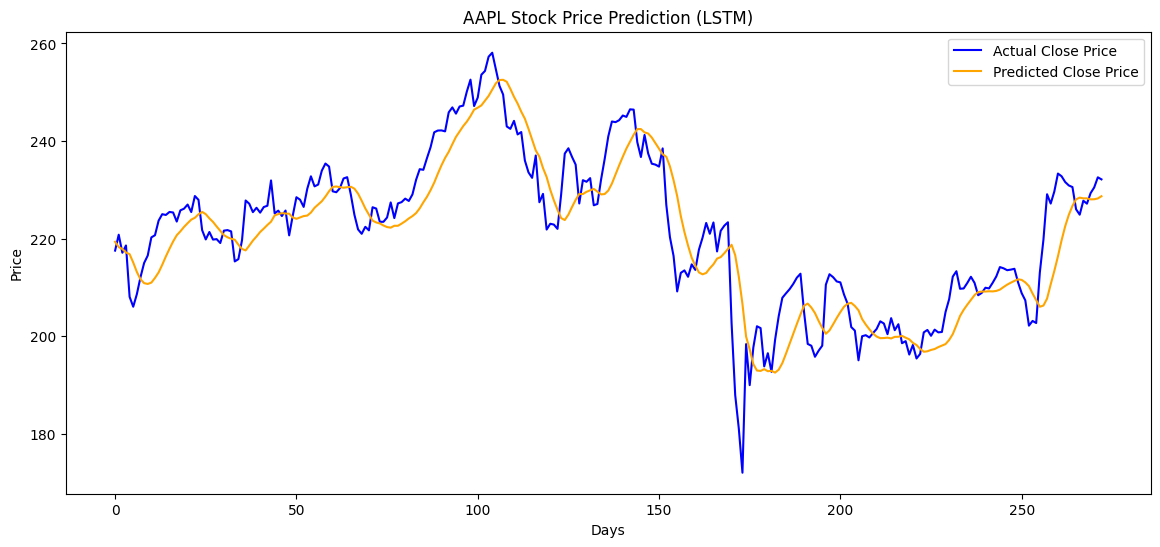

In [20]:
# Plot
plt.figure(figsize=(14,6))
plt.plot(y_test_actual, color='blue', label='Actual Close Price')
plt.plot(y_pred, color='orange', label='Predicted Close Price')
plt.title('AAPL Stock Price Prediction (LSTM)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


Root Mean Squared Error (RMSE): 7.35
Mean Absolute Error (MAE): 5.65
